In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets
import modules

In [4]:
class MomentumOptimizer(modules.Optimizer):

    def __init__(self, lr=0.1, momentum=0.9) -> None:
        self.lr = 0.1
        self.momentum = momentum
        self.v = None
    
    def update(self, param: np.ndarray, grad: np.ndarray):
        if self.v is None:
            self.v = np.zeros_like(param)

        self.v = self.momentum * self.v - self.lr * grad
        param += self.v

In [5]:
class Params(modules.OptimParams):

    optim_class = MomentumOptimizer
    params = {
        'lr': 0.1,
        'momentum': 0.1
    }

In [6]:
class NeuralNetwork(modules.BaseNeuralNetwork):

    def __init__(self, input, hidden, output) -> None:
        self.layers = [
            modules.AffineLayer(input, hidden, Params),
            modules.SigmoidLayer(),
            modules.AffineLayer(hidden, output, Params),
            modules.SigmoidLayer(),
        ]

        self.loss_function = modules.MeanSquaredError()

In [7]:
x = np.array([
    [0.01, 0.01],
    [0.01, 0.99],
    [0.99, 0.01],
    [0.99, 0.99],
])
t = np.array([
    [0.45, 0.21],
    [0.01, 0.32],
    [0.50, 0.77],
    [0.17, 0.87],
])

In [8]:
np.seterr(all='ignore')

net = NeuralNetwork(2, 47, 2)

epoch = 400

loss_list = []
acc_list = []

bar = tqdm(range(epoch))

for e in bar:
    y = net.forward(x)

    r = np.argmax(y, axis=1)

    total = x.shape[0]
    right = np.sum(r == np.argmax(t, axis=1))

    loss = net.loss(y, t)
    dloss = net.dloss()

    dx = net.backward(dloss)

    net.update()

    acc = right / total * 100
    loss_list.append(loss)
    acc_list.append(acc)
    bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:03}%"))

100%|██████████| 400/400 [00:00<00:00, 902.48it/s, loss=0.012, acc=100.0%]  


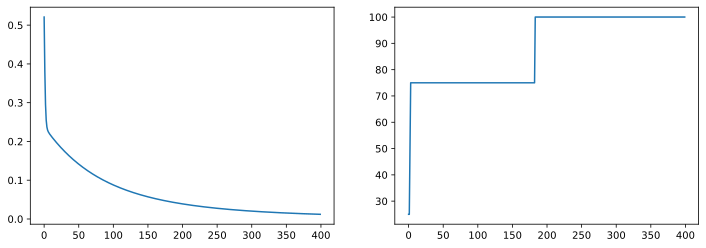

In [9]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [10]:
y = net.forward(x)
print("y:", y)
print('t:', t)

y: [[0.39152654 0.27127767]
 [0.11390942 0.32603559]
 [0.49445927 0.76228713]
 [0.19994234 0.79946257]]
t: [[0.45 0.21]
 [0.01 0.32]
 [0.5  0.77]
 [0.17 0.87]]


In [11]:
x_train, x_test, t_train, t_test = datasets.load_mnist()

In [12]:
np.seterr(all='ignore')

net = NeuralNetwork(784, 47, 10)

batch_size = 64
# train_size = (x_train.shape[0] // batch_size) * batch_size
train_size = batch_size * 100

x_train = x_train[0:train_size]
t_train = t_train[0:train_size]

epoch = 30

loss_list = []
acc_list = []

for e in range(epoch):

    bar = tqdm(range(int(train_size / batch_size)))

    bar.set_description(f'Epoch: {e}')

    indices = list(range(train_size))

    total = 0
    right = 0

    for _ in bar:
        if not indices:
            break

        batch_mask = np.random.choice(indices, batch_size, replace=False)
        for var in batch_mask:
            indices.remove(var)

        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        y = net.forward(x_batch)

        r = np.argmax(y, axis=1)
        total += x_batch.shape[0]
        right += np.sum(r == np.argmax(t_batch, axis=1))

        loss = net.loss(y, t_batch)
        dloss = net.dloss()
        dx = net.backward(dloss)

        net.update()

        acc = right / total * 100
        loss_list.append(loss)
        acc_list.append(acc)
        bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:0.3}%"))


Epoch: 29: 100%|██████████| 100/100 [00:02<00:00, 44.29it/s, loss=7.1, acc=79.0%]


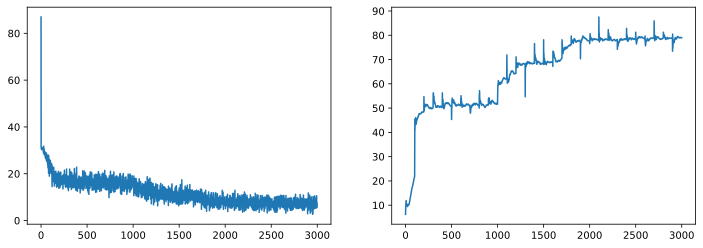

In [13]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [14]:
right = 0
total = 0

for i in range(x_test.shape[0]):
    x = x_test[i]
    t = t_test[i]
    y = net.forward(x)
    l = np.argmax(y)

    total += 1
    if l == np.argmax(t):
        right += 1

print("accuracy:", right / total * 100)


accuracy: 75.58857142857143
